In [348]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15.0, 7.5)

# Detecting playing cards

Mostly just reminding myself here of how image processing and computer vision works.

Suffice it to say, global hough transforms and naive thresholding with hardcoded parameters are _not_ an ideal way of going about this...

In [904]:
import skimage.io
from skimage.io import imread, imshow
from skimage.color import rgb2gray, rgb2hsv
from skimage.transform import rescale, rotate
from skimage.filters import median
from scipy.ndimage.filters import gaussian_filter1d
import numpy as np
from skimage.filters import threshold_adaptive, threshold_yen
from skimage.exposure import equalize_hist, rescale_intensity
from skimage.filters.rank import equalize
from skimage.morphology import disk, rectangle
from skimage.segmentation import quickshift
from skimage.morphology import dilation, binary_dilation
from sklearn.cluster import KMeans
from skimage.draw import circle
import time

/Users/joe/anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


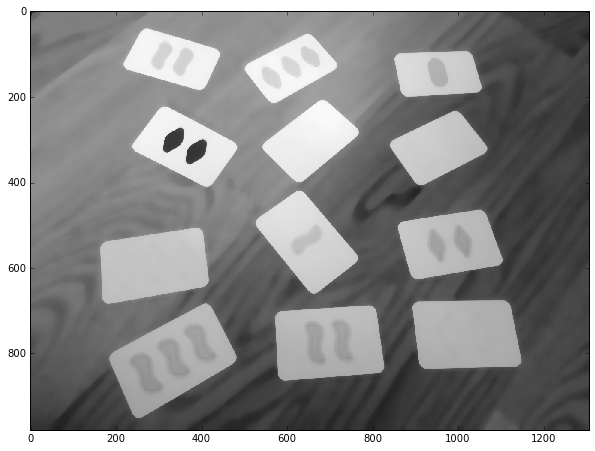

In [890]:
# Load data
# img = rotate(rescale(imread('cards1.jpg'), 0.4), 90)
img = np.rot90(rescale(imread('cards1.jpg'), 0.4))
cutoff = np.percentile(img_gray, 75)
img_hsv = rgb2hsv(img)
img_hsv[:,:,0] = 0
img_hsv[:,:,2] = 0
# img_gray = rescale_intensity(rgb2gray(img_hsv))
# img_gray = median(img_gray, rectangle(19, 19))
img_gray = rescale_intensity(rgb2gray(img))
img_gray = median(img_gray, rectangle(23, 23))
imshow(img_gray)

(0, 1306, 979, 0)

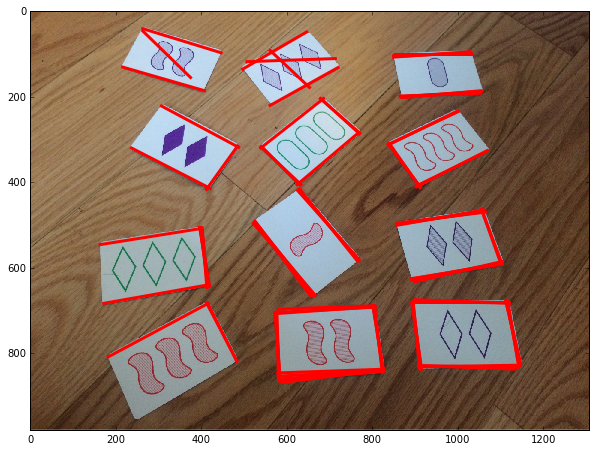

In [893]:
##### thresh = np.clip(((img_gray - cutoff)*100)+cutoff, 0, 1)

def point_outside_rect(point, rect):
    if point[0] < 0 or point[0] >= rect[0] or point[1] < 0 or point[1] >= rect[1]:
        return True
    return False

from skimage.transform import hough_line, hough_line_peaks
# cutoff = np.percentile(img_gray, 30)
# thresh = img_gray < cutoff
cutoff = np.percentile(img_gray, 75)
thresh = img_gray > cutoff
no_dark = np.multiply(thresh,  img_gray)
edges = dilation(canny(thresh, sigma=0.7))
imshow(img)
# imshow(img)

h, theta, d = hough_line(edges)
rows, cols = thresh.shape

nn = 0
segments = []

for _, angle, dist in zip(*hough_line_peaks(h, theta, d, threshold=0.37*np.max(h))):
    nn += 1
    cos_a = np.cos(angle)
    sin_a = np.sin(angle)
#     if nn != 0: continue
    y0 = (dist - 0 * cos_a) / sin_a
    y1 = (dist - cols * cos_a) / sin_a
    
#     plt.plot(dist*np.cos(angle), dist*np.sin(angle), 'wx')
    yint = dist/sin_a
    xint = dist/cos_a
    normx = cos_a
    normy = sin_a
    vecx = -normy
    vecy = normx
    if xint < 0 or xint > cols:
        # use Y intersect
        startx = 0
        starty = yint
        if vecx < 0:
            vecx = -vecx
            vecy = -vecy
    else:
        # use X intersect
        startx = xint
        starty = 0
        if vecy < 0:
            vecx = -vecx
            vecy = -vecy
    normx = normx * 8
    normy = normy * 8
#     plt.plot((0, cols), (y0, y1), '-g')

#     plt.plot([startx, startx+vecx*20], [starty, starty+vecy*20], 'w', lw=5)
    
    longest_consecutive = 0
    best_consecutive_start = None
    best_consecutive_end = None
    current_consecutive_start = None
    current_consecutive_end = None
    current_consecutive = 0
    fails = 0
    max_fails = 3
    x = startx
    y = starty
    for t in range(cols):
        x += vecx
        y += vecy
        if point_outside_rect((x, y), (cols, rows)): break
        if point_outside_rect((x+normx, y+normy), (cols, rows)): continue
        if point_outside_rect((x-normx, y-normy), (cols, rows)): continue

        v_up = no_dark[int(y+normy), int(x+normx)]
        v_down = no_dark[int(y-normy), int(x-normx)]
        
        v_up = no_dark[int(y+normy), int(x+normx)]
        v_down = no_dark[int(y-normy), int(x-normx)]
#         if v_up 
        if v_up != v_down:
            if fails > 0:
                current_consecutive_end = None
                fails = 0
            if not current_consecutive_start:
                current_consecutive_start = x
#                 plt.plot(x, y, 'cx')
            current_consecutive += 1
        elif current_consecutive_start is not None:
            if fails == 0:
                current_consecutive_end = x
            fails += 1
            if fails > max_fails:
                current_y_0 = y0 + (current_consecutive_start/cols)*(y1-y0)
                current_y_1 = y0 + (current_consecutive_end/cols)*(y1-y0)
#                 plt.plot([current_consecutive_start, current_consecutive_end], [best_y_0, best_y_1], 'r', lw=3)
                if current_consecutive > longest_consecutive:
                    longest_consecutive = current_consecutive
                    best_consecutive_start = current_consecutive_start
                    best_consecutive_end = current_consecutive_end
                current_consecutive = 0
                current_consecutive_start = None
                fails = 0
#     print(best_consecutive_start, best_consecutive_end)
    try:
        best_y_0 = y0 + (best_consecutive_start/cols)*(y1-y0)
        best_y_1 = y0 + (best_consecutive_end/cols)*(y1-y0)
    except TypeError:
        continue
    plt.plot([best_consecutive_start, best_consecutive_end], [best_y_0, best_y_1], 'r', lw=3)
    segments.append(((best_consecutive_start, best_consecutive_end), (best_y_0, best_y_1)))
                
                
#             plt.plot([x-normx, x+normx], [y-normy, y+normy])
#             plt.plot(x, y, '.')


plt.axis((0, cols, rows, 0))

## Histogram-based thresholding

I had some ideas involving thresholding using the peaks of the histogram. It's a very slow approach but I may well come back to it

Here I threshold at the first significant-looking trough, then I use K-means clustering to find the locations of cards.

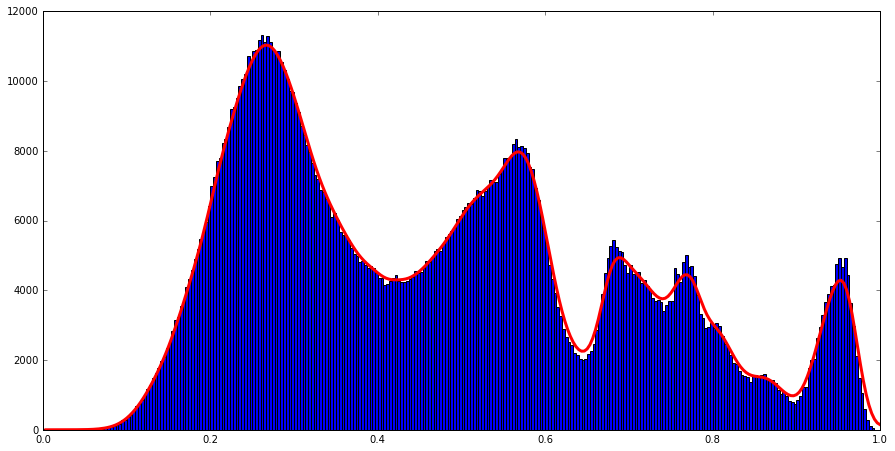

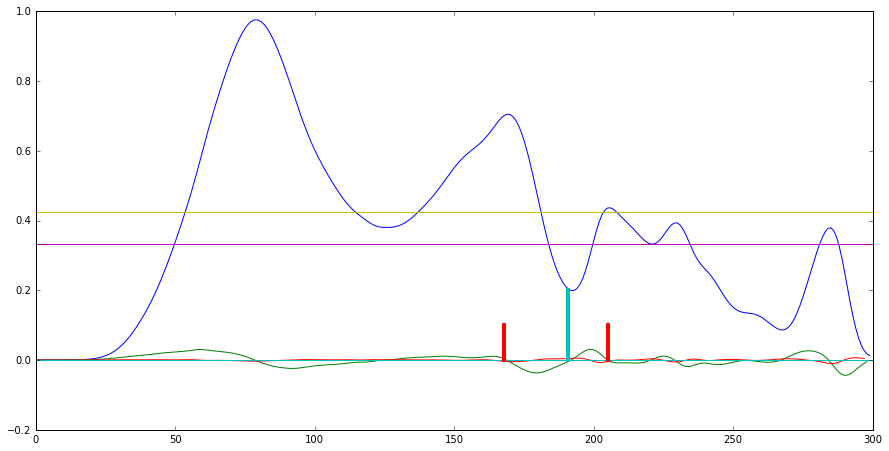

10.574378967285156


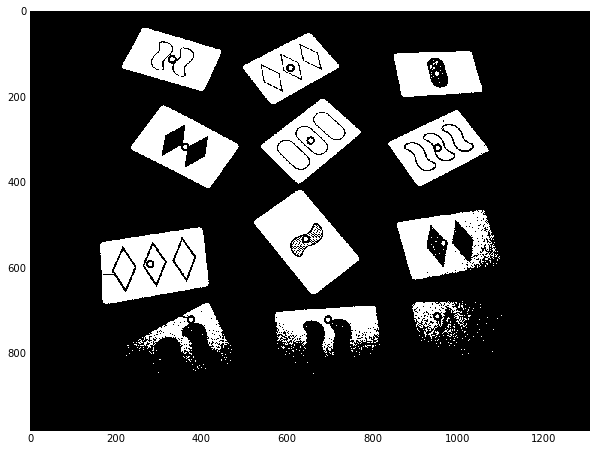

In [916]:
img_gray = rgb2gray(img)
img_hsv = rgb2hsv(img)
img_hsv[:,:,0] = 0

rescaled = rescale_intensity(img_gray)
processed = rescaled
n_bins = 300
# processed = np.clip(((processed - 0.5) * 1.1) + 0.5, 0, 1)

counts, bins, _ = plt.hist(processed.ravel(), bins=n_bins)
count_max = max(counts)
counts = counts/count_max
filtered = gaussian_filter1d(counts, 3)
plt.plot(bins[1:], filtered*count_max, 'r', lw=3)
plt.show()

halfway_point = int(len(filtered) / 2)
diff1 = np.diff(filtered)
diff2 = np.diff(diff1)
plt.plot(filtered)
plt.plot(diff1)
plt.plot(diff2)
mean_v = np.mean(filtered[halfway_point:])
std_v = np.std(filtered[halfway_point:])/2
plt.plot([0, n_bins], [0, 0])
plt.plot([0, n_bins], [mean_v, mean_v])
plt.plot([0, n_bins], [mean_v+std_v, mean_v+std_v])

crossings = np.where(np.diff(np.signbit(diff1)))[0]
found_trough = None
found_peak = None
for c in crossings:
    if c < halfway_point:
        continue
    if diff2[c] > 0:
        plt.plot([c, c], [0, 0.1], 'k', lw=4)
        found_trough = c
    if diff2[c] < 0:
        plt.plot([c, c], [0, 0.1], 'r', lw=4)
        if filtered[c] > mean_v + std_v and found_trough is not None:
            
            break
        
cutoff = found_trough / len(diff1)

plt.plot([cutoff * len(diff1), cutoff * len(diff1)], [0, 0.2], 'c', lw=4)
plt.show()

imshow(img_gray > cutoff)

thresholded = img_gray > cutoff

points = set()
for x in range(np.shape(thresholded)[0]):
    for y in range(np.shape(thresholded)[1]):
        if thresholded[x, y]:
            points.add((x, y))
np.shape(thresholded)

t = time.time()
kmeans = KMeans(n_clusters=12).fit(list(points))
print(time.time() - t)
for center in kmeans.cluster_centers_:
    rr, cc = circle(center[0], center[1], 10)
    thresholded[rr, cc] = 0
    rr, cc = circle(center[0], center[1], 5)
    thresholded[rr, cc] = 1
    
imshow(thresholded)



## Ideas

Ultimately I feel that active contours or some other approach more modern than filter+hough is the right way to go here. The cards are extremely obvious to humans, but

1. Variable lighting across the scene means that thresholding can perform surprisngly badly
    - Adaptive thresholding could be an interesting solution for it, but it is only fast at very small scales e.g. for picking out text.
2. The lines we are looking for are relatively small compared to the whole image, and might not always be exact lines (since cards can bend). Meanwhile, the hough transform ranks lines by 'longest = best', but my playing surface may include lines which are longer than the playing cards!

This makes me think that an active contour approach (which perhaps includes knowledge of the fact that I am looking for rectangles) may work best, perhaps in addition so some form of clustering on a thresholded image to help identify the basic locations of the cards.